## Code for vizualisation of Chebyshev Linear Regression task

In [33]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

from function_classes import ChebyshevKernelLinearRegression
from parse import get_x_distribution
from utils import FakeLinspaceDistribution

SAVE_FIGURES = True
DEVIICE = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Examples of linear combinations of Chebyshev polynomials with random degree between 0 and 11, with uniformly sampled x

In [34]:
NUM_POLYS = 5
SEQ_LEN = 1000
chebyshev_linear_comb_class = ChebyshevKernelLinearRegression(lowest_degree=0, highest_degree=11, #x_distribution=x_distribution)
                                                              x_distribution=FakeLinspaceDistribution(batch_shape=torch.Size((NUM_POLYS, SEQ_LEN, 1))))

x_values, y_values = next(chebyshev_linear_comb_class)

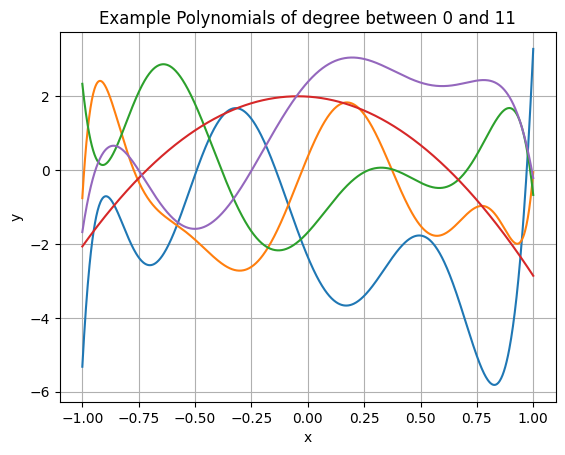

In [35]:
for x, y in zip(x_values, y_values):
    plt.plot(x.cpu(), y.cpu())
plt.xlabel("x")
plt.ylabel("y")
plt.title("Example Polynomials of degree between 0 and 11")
plt.grid()
if SAVE_FIGURES:
    plt.savefig("figures/chebyshev_polynomial_examples.pdf", format="pdf")
plt.show()

### Analytical Visualisation of distribution of normal random linear combinations of Chebyshev polynomials with random degree between 0 and 11, with uniformly sampled x

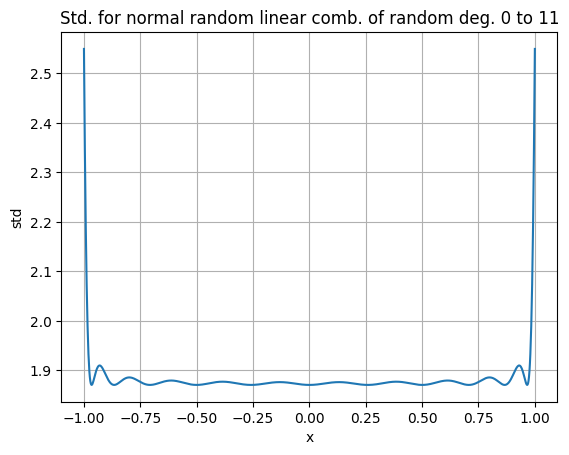

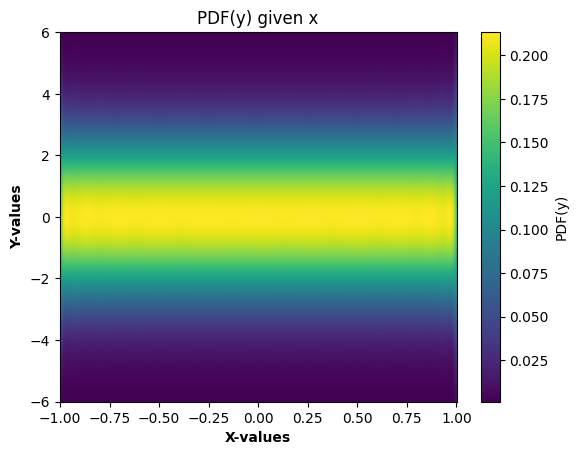

In [36]:
LOWEST_DEGREE = 0
HIGHEST_DEGREE = 11
SIGMA = 1
Y_MAX = 6

SEQ_LEN = 1000

# Sum of squared Chebyshev polynomials
summed_squared_chebyshevs = torch.zeros(SEQ_LEN, 1, device=DEVIICE)
x_values = torch.tensor(0, device=DEVIICE)
for i in range(LOWEST_DEGREE, HIGHEST_DEGREE+1):
    
    cheb_function_class = ChebyshevKernelLinearRegression(lowest_degree=i, highest_degree=i, fixed_linear_coefficients=1, different_degrees=False,
                                                          x_distribution=FakeLinspaceDistribution(batch_shape=torch.Size((1, SEQ_LEN, 1))))
    x_values, y_values = next(cheb_function_class)
    summed_squared_chebyshevs += (HIGHEST_DEGREE - i + 1) * y_values.squeeze(0)**2


# Calculate variance
variance = summed_squared_chebyshevs * SIGMA**2 / (HIGHEST_DEGREE - LOWEST_DEGREE + 1)

# Plot Standard Deviation
x_values, standard_deviation = x_values.squeeze(0), torch.sqrt(variance)
plt.plot(x_values.cpu(), standard_deviation.cpu())
plt.grid()
plt.title("Std. for normal random linear comb. of random deg. 0 to 11")
plt.xlabel("x")
plt.ylabel("std")
if SAVE_FIGURES:
    plt.savefig("figures/std_normal_random_linear_comb.pdf", format="pdf")
plt.show()


# Plot PDF(y) given x

def std_variable_normal_dist(y: np.ndarray, mean: np.ndarray | float, std: np.ndarray):
    return 1/(std * math.sqrt(2 * math.pi)) * np.exp(-0.5 * (y - mean)**2 / std**2)

std, y = np.meshgrid(standard_deviation.cpu(), np.linspace(-Y_MAX, Y_MAX, 1000)) #np.arange(-Y_MAX, Y_MAX, 0.01))
x, _ = np.meshgrid(x_values.cpu(), np.linspace(-Y_MAX, Y_MAX, 1000)) #np.arange(-Y_MAX, Y_MAX, 0.01))

z = std_variable_normal_dist(y, 0, std)

plt.pcolormesh(x, y, z, shading='nearest', linewidth=0, rasterized=True)
plt.colorbar(label="PDF(y)")
plt.ylabel("Y-values", fontweight='bold')
plt.xlabel("X-values", fontweight='bold')
plt.title("PDF(y) given x")
if SAVE_FIGURES:
    plt.savefig("figures/pdf_normal_random_linear_comb.pdf", format="pdf")
plt.show()

### Numerical Visualization of distribution of normal random linear combinations of Chebyshev polynomials with random degree between 0 and 11, and degree 5 with 2 fixed linear coefficients, with uniformly sampled x

In [37]:
def tick_format(value, _):
    return f"{value:g}"

def plot_distribution(ax: Axes, x_values: torch.Tensor, y_values: torch.Tensor, title: str = "", hide_y_axis: bool = False):

    ax.xaxis.set_major_formatter(FuncFormatter(tick_format))

    # Create the 2D histogram
    counts, xedges, yedges = np.histogram2d(x_values.reshape(-1).cpu(), y_values.reshape(-1).cpu(), bins=[100, 150], density=True)
    
    # Midpoints of bins
    x_mid = (xedges[:-1] + xedges[1:]) / 2
    y_mid = (yedges[:-1] + yedges[1:]) / 2

    # Create grid
    X, Y = np.meshgrid(x_mid, y_mid)
    C = counts.T
    
    # Plot the interpolated histogram
    c_mesh = ax.pcolormesh(X, Y, C, shading='nearest', linewidth=0, rasterized=True)

    ax.set_xlim(left=-1, right=1)
    ax.set_ylim(bottom=-Y_MAX, top=Y_MAX)

    if hide_y_axis:
        ax.tick_params(labelleft=False)

    if title:
        ax.set_title(title, fontweight='bold', fontsize=12)

    return c_mesh, C


In [38]:
NUM_EXAMPLES = int(1e6)
SEQ_LEN = 31

In [39]:
# Sample values for random linear combination of Chebyshev polynomials from degree 0 to 11
chebyshev_linear_comb_class = ChebyshevKernelLinearRegression(lowest_degree=0, highest_degree=11, #x_distribution=x_distribution)
                                                              fixed_linear_coefficients=0, different_degrees=True,
                                                              x_distribution=get_x_distribution(batch_size=NUM_EXAMPLES,
                                                                                                seq_len=SEQ_LEN,
                                                                                                x_dim=1,
                                                                                                init_kwargs={'type' : 'uniform'}))

x_values_0_11, y_values_0_11 = next(chebyshev_linear_comb_class)


In [40]:
# Sample values for random linear combination of Chebyshev polynomials od degree 5 and 2 fixed linear coefficients
chebyshev_linear_comb_class = ChebyshevKernelLinearRegression(lowest_degree=0, highest_degree=5, 
                                                              fixed_linear_coefficients=3, different_degrees=False,
                                                              x_distribution=get_x_distribution(batch_size=NUM_EXAMPLES,
                                                                                                seq_len=SEQ_LEN,
                                                                                                x_dim=1,
                                                                                                init_kwargs={'type' : 'uniform'}))

x_values_5, y_values_5 = next(chebyshev_linear_comb_class)

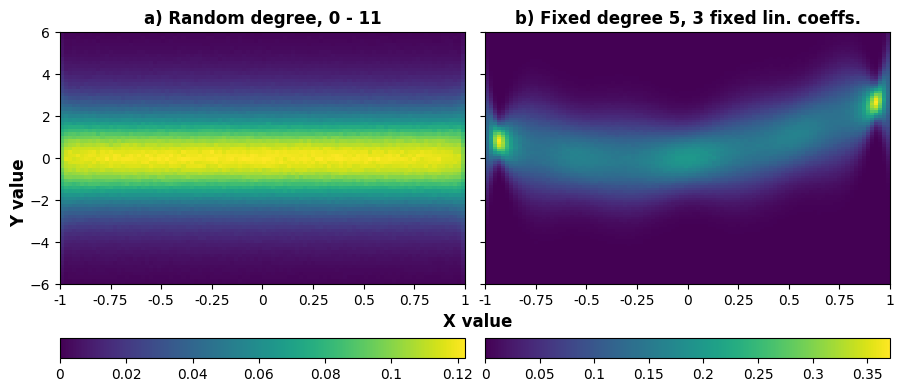

In [41]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(nrows=1, ncols=2)

c_mesh_1, _ = plot_distribution(ax1, x_values_0_11, y_values_0_11, title="a) Random degree, 0 - 11")
c_mesh_2, _ = plot_distribution(ax2, x_values_5, y_values_5, hide_y_axis=True, title="b) Fixed degree 5, 3 fixed lin. coeffs.")

wspace = 0.05
fig.subplots_adjust(left=0.07, bottom=0, top=0.9, hspace=0, wspace=wspace)

fig.text(0.5 - wspace / 4, 0.175, "X value", ha='center', va='center', fontsize=12, fontweight='bold')
fig.supylabel("Y value", fontweight='bold', fontsize=12)

c_bar = fig.colorbar(c_mesh_1, ax=[ax1], location='bottom')
c_bar.ax.xaxis.set_major_formatter(FuncFormatter(tick_format))
c_bar = fig.colorbar(c_mesh_2, ax=[ax2], location='bottom')
c_bar.ax.xaxis.set_major_formatter(FuncFormatter(tick_format))

if SAVE_FIGURES:
    fig.savefig("figures/sampled_dist_examples.pdf", format="pdf")